<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/sl_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantifying the performance of machine learning models in materials discovery

In [1]:
# %%time
# !wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh
# !chmod +x mini.sh
# !bash ./mini.sh -b -f -p /usr/local
# !conda install -q -y jupyter
# !conda install -q -y google-colab -c conda-forge
# !python -m ipykernel install --name "py39" --user

In [2]:
!pip install -q numpy pandas scipy pymatgen fdint matminer kaleido ipywidgets notebook lolopy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.1/704.1 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 30.9 MB/s eta 0:00

In [3]:
import os
os.chdir('/content')
if not os.path.exists('sl_discovery'):
  !git clone https://github.com/CitrineInformatics-ERD-public/sl_discovery.git
os.chdir('sl_discovery')

In [4]:
os.chdir('simulated_SL')

In [5]:
pip install -q pydantic==1.8

In [6]:
%load_ext autoreload
%autoreload 2
import yaml
import time
import sys
import os
import pandas as pd
import numpy as np

# load internal packages and functions
from slworkflow import SLWorkflow, RandomForestRegressorCov
import load_datasets



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# load configuration file

basedir = 'configuration_files'
dataset_path = os.path.join('dataset_configs','starrydata_zt_bulk.yaml')
sl_path = os.path.join('sl_configs','1.yaml')

with open(os.path.join(basedir,dataset_path)) as file:
    sl_config = yaml.load(file, Loader=yaml.FullLoader)

with open(os.path.join(basedir,sl_path)) as file:
    sl_config.update(yaml.load(file, Loader=yaml.FullLoader))

print(sl_config)

{'dataset': 'starrydata_zt_bulk', 'output': '8', 'categoricals': None, 'comp_class': '111-type', 'material_family': None, 'filtered': True, 'sample_form': 'Bulk', 'config_id': 1, 'n_sample': 0, 'n_training': 50, 'iterations': 100, 'trials': 100, 'batch': 1, 'discovery_break_number': 0, 'poi': None, 'holdout_fraction': 0.1, 'targets': [[0, 10]]}


In [8]:
if 'starrydata' in sl_config['dataset']:
    df = load_datasets.get_starrydata(out=sl_config['output'],
                        composition_class=sl_config['comp_class'],
                        sample_form=sl_config['sample_form'],
                        material_family=sl_config['material_family'])
    df = df.reset_index()

if 'matbench' in sl_config['dataset']:
    df = load_datasets.get_matbench_dataset(sl_config['dataset'],
                                sl_config['output'])

df.describe()

,index,sampleid,1,paperid,year,2,5,6,4,8,11,12,3,13,14,sigma_E_0,log sigma_E_0,weighted_mobility,quality_factor,log quality_factor
count,329.000000,329.000000,329.0,329.000000,329.000000,313.000000,97.000000,3.160000e+02,304.000000,329.000000,310.000000,15.000000,309.000000,3.200000e+01,0.0,309.000000,309.000000,3.090000e+02,295.000000,292.000000
mean,13439.224924,23797.015198,300.0,15937.537994,1991.039514,0.000006,0.012623,1.666316e-03,5.441104,0.135459,4.928786,0.013710,124627.080036,1.798519e+27,NaN,58617.195920,4.357361,1.938112e-02,0.046217,-1.871766
std,4743.712045,11133.851213,0.0,11073.551048,221.271330,0.000153,0.118488,2.157017e-03,3.550878,0.194548,3.552411,0.014841,155075.287978,2.991732e+27,NaN,69821.542190,0.836628,2.308571e-02,0.086436,0.986523
min,4116.000000,5646.000000,300.0,33.000000,0.000000,-0.000310,0.000001,2.495084e-08,0.000343,0.000002,-0.156699,0.002207,0.856729,5.861576e+24,NaN,2.977438,0.473843,9.844563e-07,-0.310041,-6.060731
25%,8034.000000,11900.000000,300.0,3411.000000,2013.000000,-0.000112,0.000010,2.457946e-04,3.338904,0.022329,2.505962,0.003014,21750.475015,3.786365e+25,NaN,11922.736328,4.076376,3.942119e-03,0.005976,-2.193923
50%,13198.000000,21177.000000,300.0,21244.000000,2017.000000,0.000004,0.000024,1.024893e-03,4.896789,0.068491,4.242399,0.003561,71765.936887,4.034058e+26,NaN,39840.863500,4.600329,1.317293e-02,0.022011,-1.650393
75%,18291.000000,35969.000000,300.0,24802.000000,2020.000000,0.000126,0.000049,2.146097e-03,7.018935,0.149218,6.566368,0.020630,169731.190424,1.950819e+27,NaN,77472.845188,4.889150,2.561553e-02,0.052544,-1.277280
max,20526.000000,41035.000000,300.0,31696.000000,2021.000000,0.000624,1.167230,1.064674e-02,19.031144,0.996731,19.018173,0.053755,985398.117527,1.127236e+28,NaN,361512.693813,5.558124,1.195301e-01,0.601216,-0.220969


In [9]:
df = load_datasets.featurize_composition(df, sl_config['output'])
df = load_datasets.group_and_index_formula(df, sl_config['categoricals'], sl_config['output'])
# df = df.replace([np.inf, -np.inf], np.nan)

if sl_config['categoricals'] != None:
    df = pd.get_dummies(df, columns=sl_config['categoricals'])

StrToComposition:   0%|          | 0/329 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/329 [00:00<?, ?it/s]

/content/sl_discovery/simulated_SL/load_datasets.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('formula', as_index=False).mean().reset_index()


<Axes: >

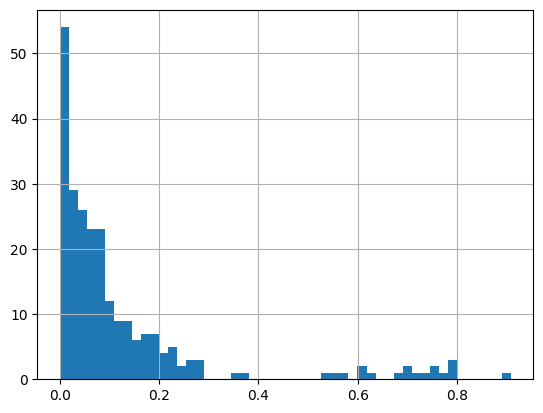

In [10]:
# review output data distribution
df[sl_config['output']].hist(bins=50)

In [11]:
# get categorical / one-hot generated features
encoded_features = []
if sl_config['categoricals'] != None:
    for feature in sl_config['categoricals']:
        encoded_features.extend([x for x in df.keys() if feature in x])

# get all features in one list ('formula' is not a feature but added for plotting convenience)
features = [x for x in df.keys() if 'Magpie' in x]+encoded_features+['formula']

# get features + output
data = df[features+[sl_config['output']]]
data.describe()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,8
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,...,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,24.590909,61.838843,37.247934,40.503349,11.597908,30.268595,40.780992,84.231405,43.450413,62.545576,...,0.361553,0.485054,0.224443,144.830579,222.260331,77.429752,188.948739,26.518139,175.533058,0.123951
std,7.362149,12.125334,11.474150,7.164921,3.163690,9.980799,12.931257,2.498997,12.791644,4.362883,...,0.241185,0.320198,0.512083,37.050490,11.867980,33.213962,14.506551,13.643557,36.597521,0.180571
min,3.000000,50.000000,11.000000,21.516667,3.777778,12.000000,1.000000,78.000000,5.000000,52.224422,...,0.000000,0.000000,0.000000,12.000000,166.000000,4.000000,110.000000,1.733333,12.000000,0.000002
25%,22.000000,51.000000,28.000000,34.720000,9.220000,26.000000,43.000000,85.000000,38.250000,61.601639,...,0.198465,0.264617,0.000000,141.000000,225.000000,63.000000,186.032917,18.330881,166.000000,0.021135
50%,22.000000,51.500000,37.000000,39.278333,11.414497,27.000000,43.000000,85.000000,42.000000,61.900000,...,0.487768,0.666676,0.000000,141.000000,225.000000,63.000000,187.297541,27.989978,166.000000,0.062484
75%,27.000000,72.000000,48.000000,44.654167,13.357333,28.000000,44.000000,85.000000,42.000000,62.295833,...,0.516165,0.688209,0.000000,166.000000,229.000000,84.000000,195.000000,30.333333,194.000000,0.138675
max,51.000000,83.000000,61.000000,66.663333,21.988889,52.000000,85.000000,90.000000,84.000000,87.000000,...,0.724661,0.951721,2.110663,225.000000,229.000000,213.000000,227.700000,87.777778,229.000000,0.908476


In [12]:
# cache featurized dataset
data.to_csv(os.path.join('featurized_datasets',dataset_path.split(os.sep)[1].replace('.yaml', '.csv')))

In [13]:
# results path / create output directory
basedir = 'sl_results'
timestamp = time.strftime("%d%h%y")
config_id = str(sl_config['config_id'])
dataset_id = sl_config['dataset']
results_directory = os.path.join(basedir,timestamp,config_id,dataset_id)

if not os.path.exists(results_directory):
    os.makedirs(results_directory)

config_output_path = open('{}{}.yaml'.format(results_directory, config_id), 'w')
yaml.dump(sl_config, config_output_path, allow_unicode=True)

# calc holdout set size
sl_config['holdout_set_size'] = int(sl_config['holdout_fraction']*len(data))


In [ ]:
for target in sl_config['targets']:

    output_file_path = os.path.join(results_directory,'{}-{}-{}-{}-{}-{}.csv'.format(
        dataset_id, config_id, len(data)-sl_config['holdout_set_size'], sl_config['holdout_set_size'], target[0], target[1]))

    # print(len(data), sl_config['n_training'], sl_config['holdout_set_size'], sl_config['iterations'])
    print('Output file: {}'.format(output_file_path))
    wf = SLWorkflow({
        'dataset': data,  # name of featurized dataset
        'n_sample': sl_config['n_sample'],
        'target_variable': sl_config['output'],  # column of target variable
        'ignore_vars': ['formula', 'Composition class'],  # list of columns to ignore in ML
        'holdout_set_size': sl_config['holdout_set_size'], # samples to test against
        'target_value': target,  # target value for model to look for
        'n_priors': sl_config['n_training'],  # 8 is minimum here!
        'batch_size': sl_config['batch'],  # how many samples to select per batch
        'n_trials': sl_config['trials'],  # how many trials per method (for averaging purposes)
        'n_iterations': sl_config['iterations'],  # how many iterations of SL to run for each method
        'poi':sl_config['poi'],
        'discovery_break_number':sl_config['discovery_break_number'],
        'acquisition_functions': [  # which methods to use for selecting candidates
            'EV',
            'EI',
            'MU',
            'Random',
        ],
        'learners': [  # which models to use for SL
            #RandomForestRegressor(),
            RandomForestRegressorCov()
            #GaussianProcessRegressor()
        ],
    })


    # Run the SL workflow
    wf.run(verbose=False, plot_results=False)
    wf.results_all.to_csv(output_file_path)

Output file: sl_results/28Aug23/1/starrydata_zt_bulk/starrydata_zt_bulk-1-218-24-0-10.csv
running...
21 candidates inside the [0, 10] percentile range with property 8 between 0.0 and 0.0024
